#  Minimum Spanning Tree (MST) in a graph

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import random
import time
import math
import sorting

# Graph generation

In [2]:
def gen_graph(n: int, m: int, k: int = 100):
    matrix = np.zeros((n, n), dtype=int)
    for _ in range(m):
        while True:
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            w = random.randint(1, k - 1)
            
            if i != j and matrix[i][j] == 0:
                matrix[i][j] = matrix[j][i] = w
                break
                
    graph = nx.from_numpy_matrix(np.matrix(matrix), create_using=nx.Graph)
    return graph

def get_weighted_edges(graph):
    edges = []
    for i, j, w_dict in graph.edges(data=True):
        edges.append((w_dict['weight'], i, j))
    return edges

In [3]:
def draw_graph(graph, colored_edges = [], draw_weights: bool = True):
    layout = nx.spring_layout(graph)
    fig, ax = plt.subplots(figsize=(15,8))
    edge_color = ['red' if e in colored_edges else 'black' for e in graph.edges()]
    nx.draw(graph, layout, with_labels=True, edge_color=edge_color, font_color="white")

    if draw_weights:
        labels = nx.get_edge_attributes(graph,'weight')
        nx.draw_networkx_edge_labels(graph, pos=layout, edge_labels=labels)
    plt.show() 

## Prim's algorithm

### Priority queue

In [4]:
class Heap:
    def __init__(self):
        self.h = [-1]
        self.v = []
        self.pos = []
        self.n = 0

    def get_min(self):
        return self.v[self.h[1]]

    def _swap(self, i, j):
        self.h[i], self.h[j] = self.h[j], self.h[i]
        self.pos[self.h[i]] = i
        self.pos[self.h[j]] = j

    def add(self, x):
        self.v.append(x)
        self.h.append(len(self.v) - 1)
        self.n += 1
        self.pos.append(self.n)
        self._sift_up(self.n)

    def delete(self, i):
        i = self.pos[i]
        self._swap(i, self.n)
        self.n -= 1
        self._sift_down(i)
        self._sift_up(i)
    
    def decrease_key(self, i, x):
        self.v[i] = x
        i = self.pos[i]
        self._sift_up(i)

    def extract_min(self):
        x = self.v[self.h[1]]
        self._swap(1, self.n)
        self.n -= 1
        self._sift_down(1)
        return x

    def _sift_up(self, i):
        while i > 1 and self.v[self.h[i // 2]] > self.v[self.h[i]]:  # пока мы не корень и отец нас больше
            self._swap(i, i // 2)
            i //= 2

    def _sift_down(self, i):
        while True:
            child = 2 * i
            if child + 1 <= self.n and self.v[self.h[child + 1]] < self.v[self.h[child]]:  # выбрать меньшего из детей
                child += 1
            if not (child <= self.n and self.v[self.h[child]] < self.v[self.h[i]]):
                break  # если все дети не меньше нас, это конец
            self._swap(child, i)
            i = child  # перейти в ребёнка

In [237]:
def test_heap():
    times = []
    ns = []
    for n in range(10000, 100000, 10000):
        a = list(range(n))
        s = np.random.shuffle(a)
        h = Heap()
        start = time.perf_counter_ns()
        for x in a:
            h.add(x)
        p0 = h.get_min()
        for x in a:
            p = h.extract_min() 
            assert p0 <= p
        finish = time.perf_counter_ns()
        
        ns.append(n)
        times.append(finish - start) 
    return times, ns

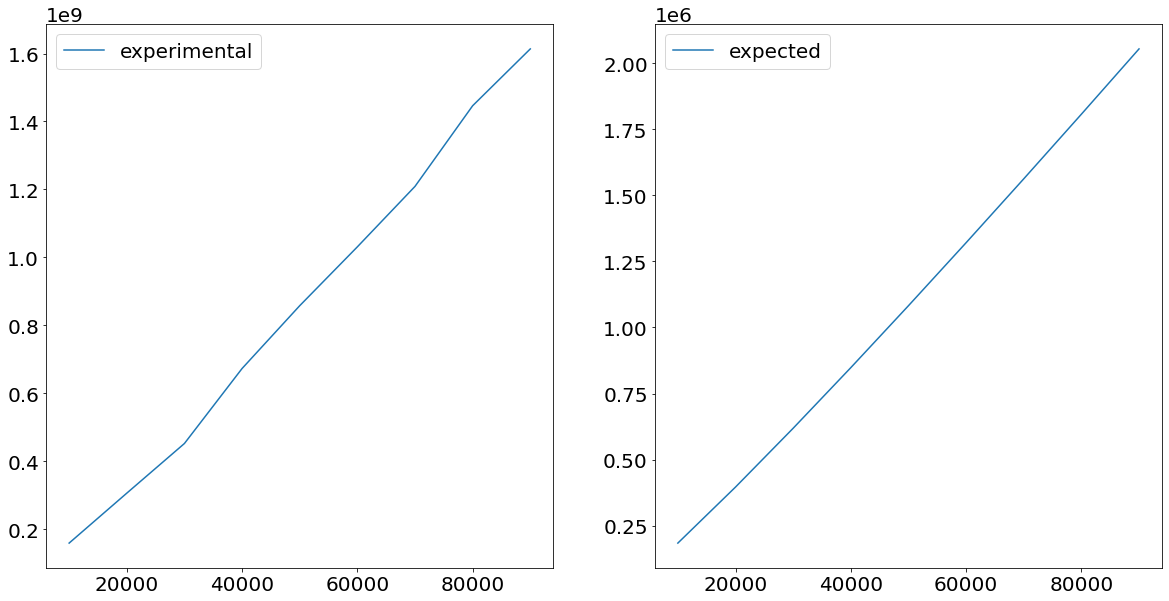

In [238]:
times, ns = test_heap()        
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)  
ax[0].plot(ns, times, label='experimental')
ax[1].plot(ns, [2 * n * np.log(n) for n in ns], label='expected')
ax[0].legend()
ax[1].legend()
plt.show()

In [5]:
def prim(graph):
    n = len(graph.nodes())
    
    edges = get_weighted_edges(graph)

    used = [True] + [False] * (n - 1)
    d = [0] + [math.inf] * (n - 1)
    p = [-1] * n
    
    h = Heap()
    
    for v in graph.nodes():
        h.add((d[v], v))
    
    while h.n > 0:
        dv, v = h.extract_min()
        used[v] = True
        for u in graph[v]:
            w = graph[v][u]['weight']
            if not used[u] and w < d[u]:
                d[u] = w
                h.decrease_key(u, (d[u], u))
                p[u] = v
    
    return [(min(p[v], v), max(p[v], v)) for v in graph.nodes() if v != 0]

## Kruskal's algorithm

### Disjoint set

In [15]:
class DisjointSet:
    def __init__(self, vertices):
        self.vertices = list(vertices)
        self.parent = list(vertices)
        self.rank = [0] * len(vertices)
        
    def find(self, v):
        if self.parent[v] == v:
            return v
        else:
            self.parent[v] = self.find(self.parent[v])
            return self.parent[v]

    def union(self, v0, v1):
        root0 = self.find(v0)
        root1 = self.find(v1)
        if self.rank[root0] < self.rank[root1]:
            self.parent[root0] = root1
        elif self.rank[root0] > self.rank[root1]:
            self.parent[root1] = root0
        else:
            self.parent[root1] = root0
            self.rank[root0] += 1

In [16]:
def kruskal(graph):
    edges = sorted(get_weighted_edges(graph)) # change to sorting.qsort to get alternative result
    mst_edges = []
    s = DisjointSet(graph.nodes())
        
    for w, i, j in edges:
        rooti = s.find(i)
        rootj = s.find(j)
        if rooti != rootj:
            s.union(i, j)   
            mst_edges.append((i, j))
    return mst_edges

## MST algorithm compare

In [17]:
def test_algorithms(algs, ret: int=10, n_max=1000, n_step=100):
    results = []
    
    for n in range(n_step, n_max + n_step, n_step):
        for m in range(n, n * (n - 1) // 2, 2 * n):
            graph = gen_graph(n, m)
            for alg, alg_tag in algs:
                times = []
                for _ in range(ret):
                    start = time.perf_counter_ns()
                    mst_edges = alg(graph)  
                    finish = time.perf_counter_ns()
                    times.append(finish - start) 
                results.append((alg_tag, n, m, sum(times) / ret))
    return pd.DataFrame.from_records(results, columns=['algorithm', 'vertices', 'edges', 'time [ns]'])

In [18]:
def show_results(results, n_max=500, n_step=100):
    for n in range(n_step, n_max + n_step, n_step):
        plt.rcParams.update({'font.size': 20})
        results_n = results[results['vertices'] == n]
        fig, ax = plt.subplots(figsize=(20, 10))

        kruskal_results_n = results_n[results_n['algorithm'] == 'kruskal']
        ax.plot(kruskal_results_n['edges'], kruskal_results_n['time [ns]'], label='kruskal')

        prim_results_n = results_n[results_n['algorithm'] == 'prim']
        ax.plot(prim_results_n['edges'], prim_results_n['time [ns]'], label='prim')

        ax.set_title(f'MST algorithm compare |V|={n}')
        ax.set_xlabel('Number of edges')
        ax.set_ylabel('Time [ns]')
        ax.legend()
        ax.grid(True)
        plt.plot()

,algorithm,vertices,edges,time [ns]
0,kraskal,300,300,1404112.6
1,prim,300,300,5356245.9
2,kraskal,300,900,1403315.6
3,prim,300,900,5273867.7
4,kraskal,300,1500,2233110.1
...,...,...,...,...
145,prim,300,43500,116689282.1
146,kraskal,300,44100,82550562.4
147,prim,300,44100,119641078.3
148,kraskal,300,44700,92811123.5


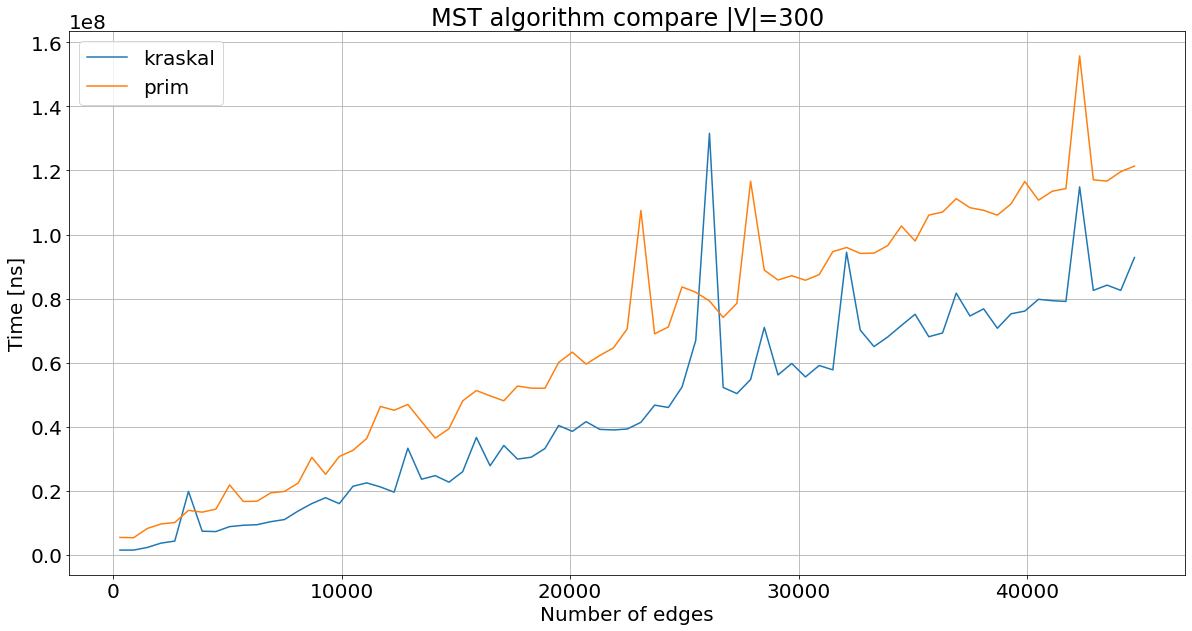

In [19]:
n, step = 300, 300
results = test_algorithms([(kruskal, 'kruskal'), (prim, 'prim')], ret=10, n_max=n, n_step=step)
show_results(results, n_max=n, n_step=step)
results

## MST example

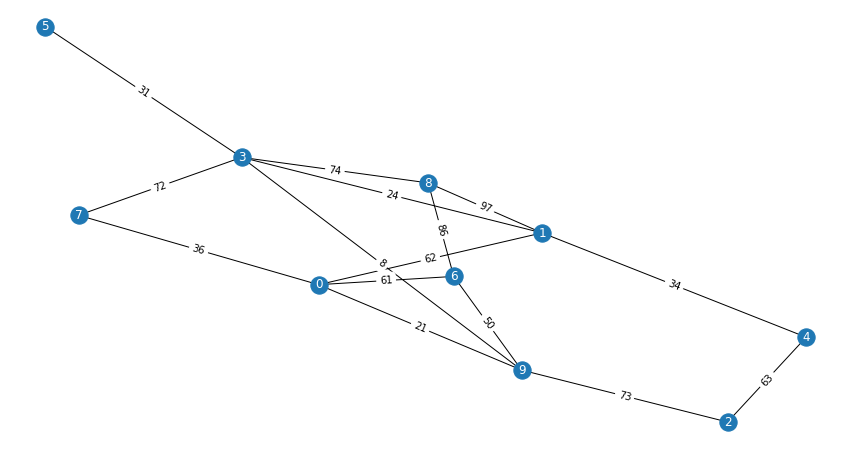

In [192]:
g = gen_graph(10, 15)
draw_graph(g)

[(3, 9), (0, 9), (1, 3), (3, 5), (1, 4), (0, 7), (6, 9), (2, 4), (3, 8)]


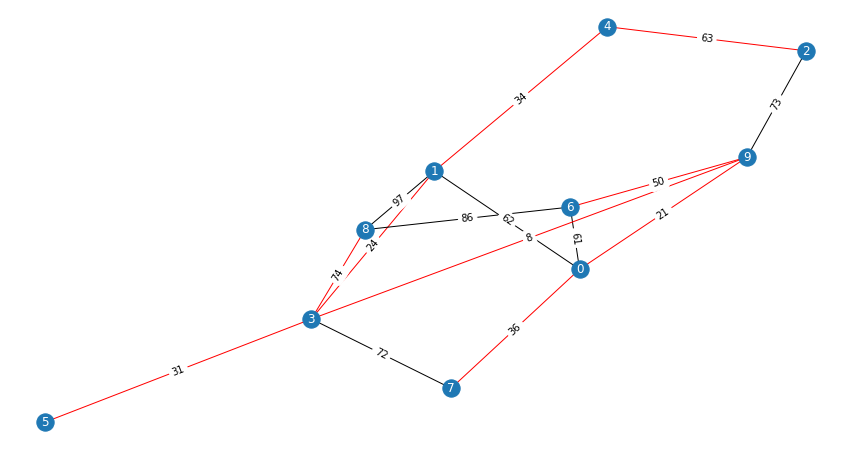

In [193]:
edges = kruskal(g)
print(edges)
draw_graph(g, edges)

[(1, 3), (2, 4), (3, 9), (1, 4), (3, 5), (6, 9), (0, 7), (3, 8), (0, 9)]


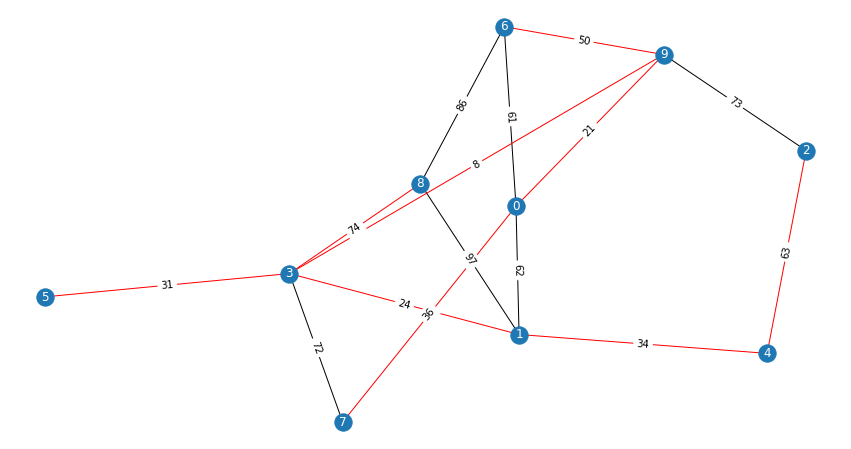

In [194]:
edges = prim(g)
print(edges)
draw_graph(g, edges)